## Tutoriel : interagir avec le système de stockage S3 du SSP Cloud (MinIO)

In [2]:
import os

import pandas as pd
import s3fs
import zipfile

### Récupérer les données d'un challenge

In [3]:
# Create filesystem object
S3_ENDPOINT_URL = "https://" + os.environ["AWS_S3_ENDPOINT"]
fs = s3fs.S3FileSystem(client_kwargs={'endpoint_url': S3_ENDPOINT_URL})

In [4]:
# Lister les challenges
fs.ls("gvimont/diffusion/hackathon-minarm-2024")

['gvimont/diffusion/hackathon-minarm-2024/AIVSAI',
 'gvimont/diffusion/hackathon-minarm-2024/Acoustique',
 'gvimont/diffusion/hackathon-minarm-2024/Similarité']

In [5]:
# Lister les fichiers d'un challenge
fs.ls("gvimont/diffusion/hackathon-minarm-2024/Similarité")

['gvimont/diffusion/hackathon-minarm-2024/Similarité/.keep',
 'gvimont/diffusion/hackathon-minarm-2024/Similarité/stanford0-car-dataset-by-classes-folder.zip']

In [6]:
# Télécharger les données dans le service
PATH_IN = 'gvimont/diffusion/hackathon-minarm-2024/Similarité/stanford0-car-dataset-by-classes-folder.zip'
fs.download(PATH_IN, 'data/archive.zip')

[None]

In [7]:
# Décompresser les données
with zipfile.ZipFile("data/archive.zip","r") as zip_file:
    zip_file.extractall("data/")

Data Visualisation

In [8]:
car_count_dict = {}
for folder_name in os.listdir('data/stanford-car-dataset-by-classes-folder/car_data/car_data/train'):
    count = len(os.listdir(os.path.join('data/stanford-car-dataset-by-classes-folder/car_data/car_data/train', folder_name)))
    car_count_dict[folder_name] = count

for folder_name in os.listdir('data/stanford-car-dataset-by-classes-folder/car_data/car_data/test'):
    count = len(os.listdir(os.path.join('data/stanford-car-dataset-by-classes-folder/car_data/car_data/test', folder_name)))
    car_count_dict[folder_name] += count

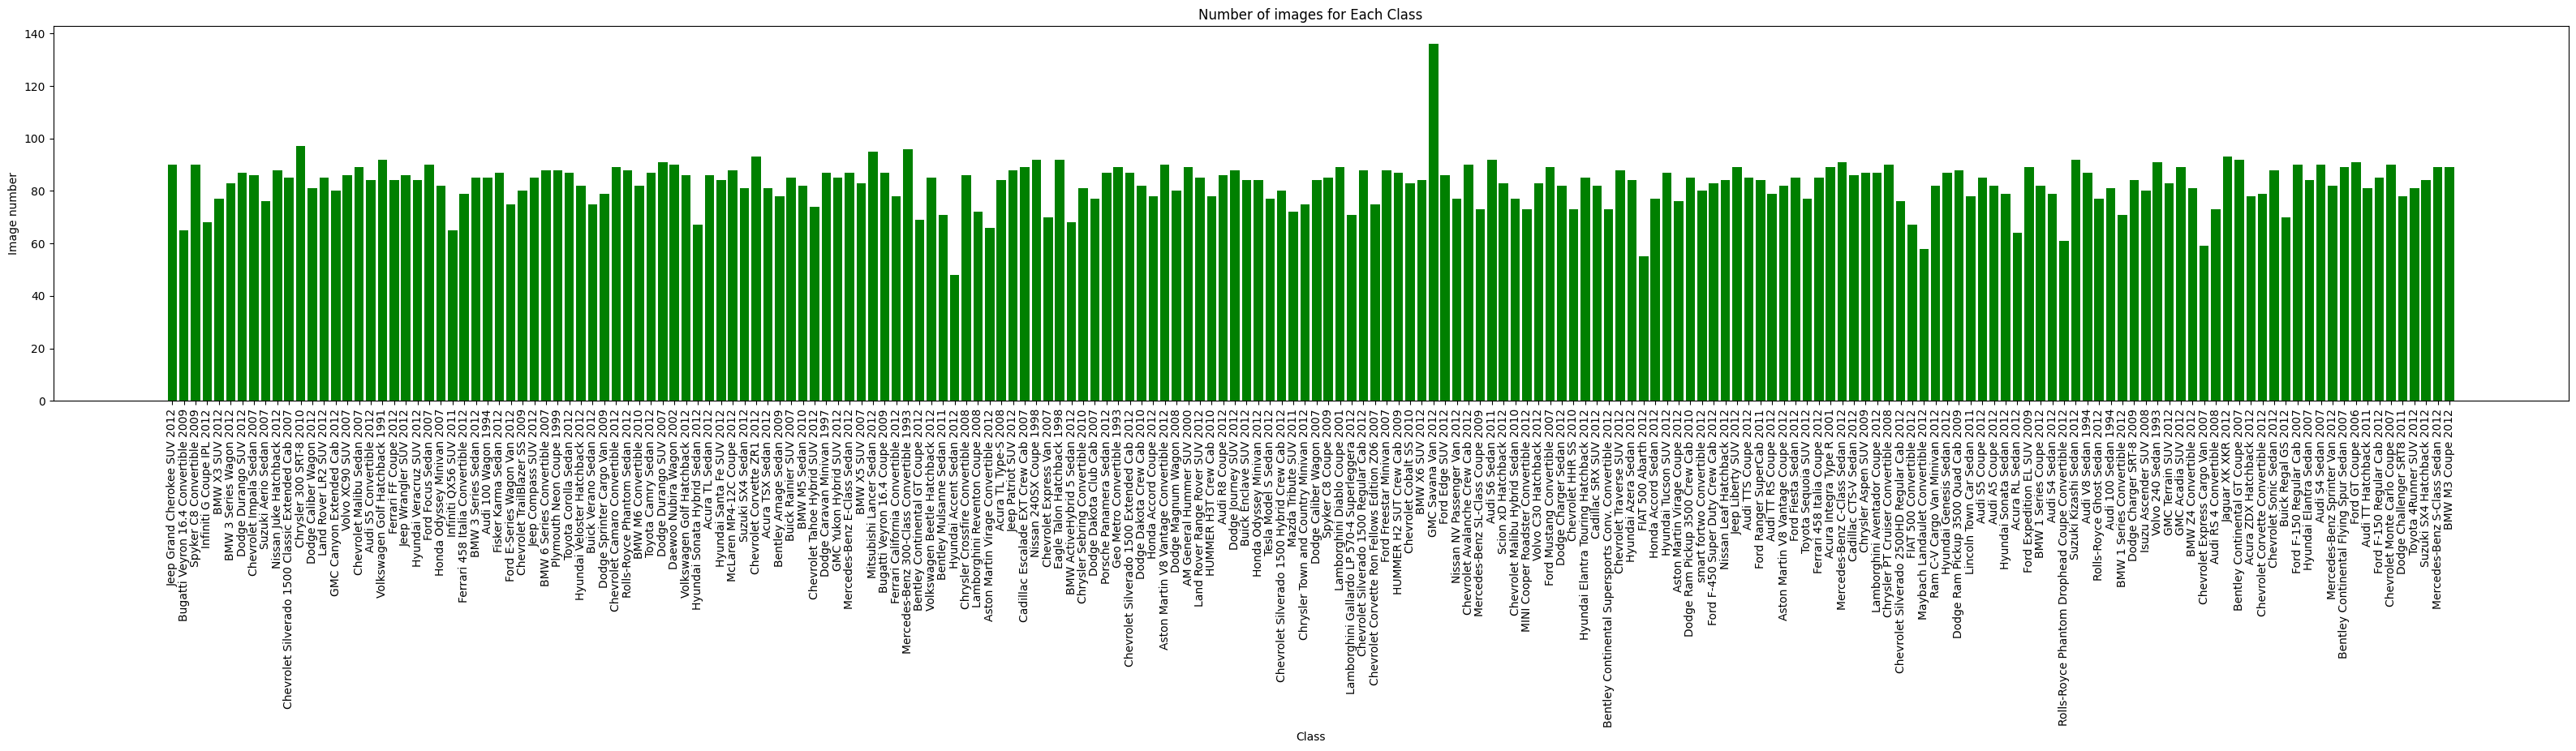

In [10]:
import matplotlib.pyplot as plt
plt.figure(figsize=(40, 6))
plt.bar(car_count_dict.keys(), car_count_dict.values(), color='green')
plt.xlabel('Class')
plt.ylabel('Image number')
plt.title('Number of images for Each Class')
plt.xticks(rotation=90)
plt.show()

NB : les données peuvent être également téléchargées directement si besoin, pour être utilisées hors du SSP CLoud.
Exemple pour le fichier ci-dessus (même format de lien pour les autres challenges) : 

http://minio.lab.sspcloud.fr/gvimont/diffusion/hackathon-minarm-2024/AIVSAI/HC3.zip

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader
import time
import torchvision
from torchvision import datasets, models, transforms

In [12]:
def train_model(model, criterion, optimizer, scheduler, train_loader, val_loader, n_epochs=1):
    losses = []
    accuracies = []
    test_accuracies = []
    model.train()
    for epoch in range(n_epochs):
        since = time.time()
        running_loss = 0.0
        running_corrects = 0
        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            with torch.set_grad_enabled(True):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects.double() / len(train_loader.dataset)
        print(f"Epoch {epoch + 1}/{n_epochs}, Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.4f}")
        losses.append(epoch_loss)
        accuracies.append(epoch_acc)

        model.eval()
        test_acc = eval_model(model, val_loader)
        test_accuracies.append(test_acc)

        model.train()
        scheduler.step(test_acc)
        time_elapsed = time.time() - since
        print(f"Epoch duration: {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s")

    print('Finished Training')
    return model, losses, accuracies, test_accuracies

    

In [13]:
#version ReduceLROnPlateau
def train_model2(model, criterion, optimizer, scheduler, train_loader, val_loader, n_epochs=1):
    losses = []
    accuracies = []
    test_accuracies = []
    model.train()
    for epoch in range(n_epochs):
        since = time.time()
        running_loss = 0.0
        running_corrects = 0
        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            with torch.set_grad_enabled(True):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects.double() / len(train_loader.dataset)
        print(f"Epoch {epoch + 1}/{n_epochs}, Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.4f}")
        losses.append(epoch_loss)
        accuracies.append(epoch_acc)
        model.eval()
        test_acc = eval_model(model, val_loader)
        test_accuracies.append(test_acc)
        model.train()
        scheduler.step(test_acc)
        time_elapsed = time.time() - since
        print(f"Epoch duration: {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s")
    print('Finished Training')
    return model, losses, accuracies, test_accuracies

In [14]:
def eval_model(model, val_loader):
    corrects = 0
    total = 0
    model.eval()
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            corrects += torch.sum(preds == labels.data)
            total += labels.size(0)
    acc = corrects.double() / total
    print(f'Test Acc: {acc:.4f}')
    return acc

In [17]:
if __name__ == '__main__':
    # Data transforms
    data_transforms = {
        'train': transforms.Compose([
            transforms.RandomResizedCrop(224),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
        'test': transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
    }

    data_dir = '/home/onyxia/work/6milarit-7/data/stanford-car-dataset-by-classes-folder/car_data/car_data'

    image_datasets = {x: datasets.ImageFolder(
                root=data_dir + '/' + x,
                transform=data_transforms[x])
                for x in ['train', 'test']}

    train_classes = image_datasets['train'].classes

    # Create data loaders
    dataloaders = {x: DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=2)
                   for x in ['train', 'test']}
    dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}

    # Initialize model
    model = models.resnet18(pretrained=True)
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, 196)

    # Use GPU if available
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(device)
    model = model.to(device)

    # Loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    scheduler = ReduceLROnPlateau(optimizer, mode='max', patience=3, threshold=0.9)

    # Train the model
    model, training_losses, training_accs, test_accs = train_model(model, criterion, optimizer, scheduler,
                                                                   dataloaders['train'], dataloaders['test'], n_epochs=15)



cuda:0
Epoch 1/15, Loss: 4.9725, Acc: 0.0351
Test Acc: 0.1659
Epoch duration: 1m 44s
Epoch 2/15, Loss: 3.9566, Acc: 0.1308
Test Acc: 0.3215
Epoch duration: 1m 38s
Epoch 3/15, Loss: 3.3339, Acc: 0.2345
Test Acc: 0.4404
Epoch duration: 1m 42s
Epoch 4/15, Loss: 2.8998, Acc: 0.3221
Test Acc: 0.5304
Epoch duration: 1m 39s
Epoch 5/15, Loss: 2.5938, Acc: 0.3784
Test Acc: 0.5897
Epoch duration: 1m 35s
Epoch 6/15, Loss: 2.3441, Acc: 0.4305
Test Acc: 0.6316
Epoch duration: 1m 34s
Epoch 7/15, Loss: 2.1603, Acc: 0.4703
Test Acc: 0.6830
Epoch duration: 1m 48s
Epoch 8/15, Loss: 2.0185, Acc: 0.5014
Test Acc: 0.6999
Epoch duration: 1m 34s
Epoch 9/15, Loss: 1.8885, Acc: 0.5274
Test Acc: 0.7294
Epoch duration: 1m 32s
Epoch 10/15, Loss: 1.8097, Acc: 0.5566
Test Acc: 0.7275
Epoch duration: 1m 35s
Epoch 11/15, Loss: 1.4252, Acc: 0.6585
Test Acc: 0.8118
Epoch duration: 1m 37s
Epoch 12/15, Loss: 1.2629, Acc: 0.6982
Test Acc: 0.8164
Epoch duration: 1m 37s
Epoch 13/15, Loss: 1.2166, Acc: 0.7049
Test Acc: 0.817

In [18]:

if __name__ == '__main__':
    # Data transforms
    data_transforms = {
        'train': transforms.Compose([
            transforms.Resize((400,400)),
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(15),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ]),
        'test': transforms.Compose([
            transforms.Resize((400,400)),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ]),
    }

    # Load data
    data_dir = '/home/onyxia/work/6milarit-7/data/stanford-car-dataset-by-classes-folder/car_data/car_data'

    image_datasets = {x: datasets.ImageFolder(
                root=data_dir + '/' + x,
                transform=data_transforms[x])
                for x in ['train', 'test']}

    # Afficher les classes pour l'ensemble de données de formation
    train_classes = image_datasets['train'].classes
    print("Classes in train dataset:", train_classes)

    # Create data loaders
    dataloaders = {x: DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=2)
                   for x in ['train', 'test']}
    dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}

    # Initialize model
    model = models.resnet18(pretrained=True)
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, 196)

    # Utilisation du GPU si disponible
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Dispositif utilisé :", device)
model = model.to(device)

# Identifier la dernière couche convolutive dans ResNet-18
target_layer = model.layer4[-1]

# Enregistrement du modèle
torch.save(model.state_dict(), "./trainedModelFinal2.pt")

# Loss function et optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
scheduler = ReduceLROnPlateau(optimizer, mode='max', patience=3, threshold=0.9)

# Train the model
model, training_losses, training_accs, test_accs = train_model(model, criterion, optimizer, scheduler,
                                                               dataloaders['train'], dataloaders['test'], n_epochs=15)



Classes in train dataset: ['AM General Hummer SUV 2000', 'Acura Integra Type R 2001', 'Acura RL Sedan 2012', 'Acura TL Sedan 2012', 'Acura TL Type-S 2008', 'Acura TSX Sedan 2012', 'Acura ZDX Hatchback 2012', 'Aston Martin V8 Vantage Convertible 2012', 'Aston Martin V8 Vantage Coupe 2012', 'Aston Martin Virage Convertible 2012', 'Aston Martin Virage Coupe 2012', 'Audi 100 Sedan 1994', 'Audi 100 Wagon 1994', 'Audi A5 Coupe 2012', 'Audi R8 Coupe 2012', 'Audi RS 4 Convertible 2008', 'Audi S4 Sedan 2007', 'Audi S4 Sedan 2012', 'Audi S5 Convertible 2012', 'Audi S5 Coupe 2012', 'Audi S6 Sedan 2011', 'Audi TT Hatchback 2011', 'Audi TT RS Coupe 2012', 'Audi TTS Coupe 2012', 'Audi V8 Sedan 1994', 'BMW 1 Series Convertible 2012', 'BMW 1 Series Coupe 2012', 'BMW 3 Series Sedan 2012', 'BMW 3 Series Wagon 2012', 'BMW 6 Series Convertible 2007', 'BMW ActiveHybrid 5 Sedan 2012', 'BMW M3 Coupe 2012', 'BMW M5 Sedan 2010', 'BMW M6 Convertible 2010', 'BMW X3 SUV 2012', 'BMW X5 SUV 2007', 'BMW X6 SUV 2012'

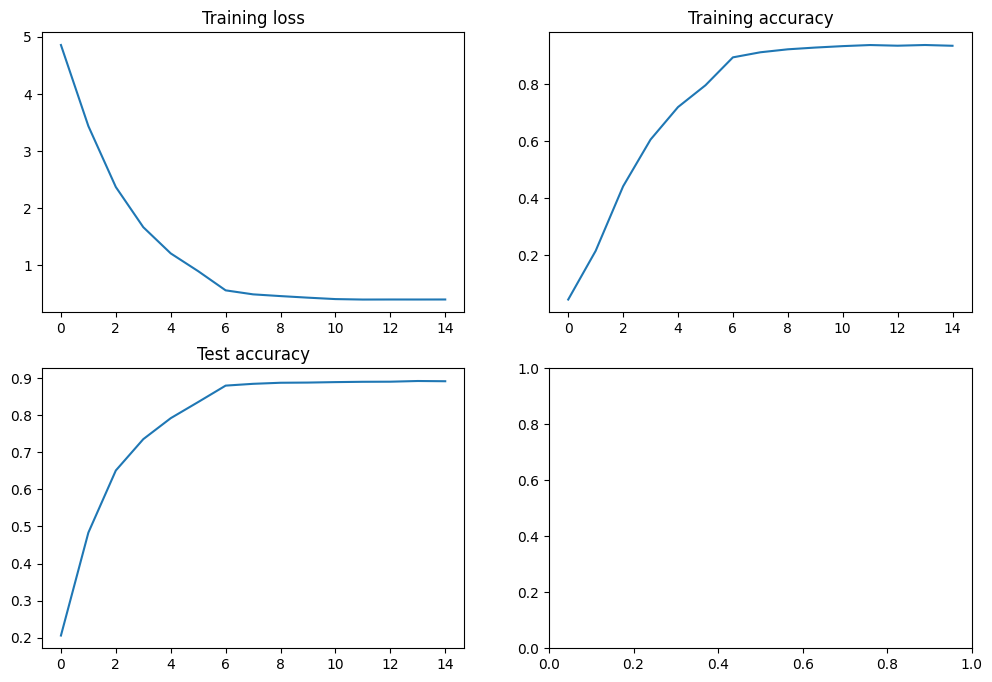

In [19]:
# Save the trained model
#torch.save(model.state_dict(), "./trainedModelFinal.pt")

training_accs_np = [acc.cpu().numpy() if acc.is_cuda else acc.numpy() for acc in training_accs]
test_accs_np = [acc.cpu().numpy() if acc.is_cuda else acc.numpy() for acc in test_accs]

# Plot results
fig, axarr = plt.subplots(2, 2, figsize=(12, 8))
axarr[0, 0].plot(training_losses)
axarr[0, 0].set_title("Training loss")
axarr[0, 1].plot(training_accs_np)
axarr[0, 1].set_title("Training accuracy")
axarr[1, 0].plot(test_accs_np)
axarr[1, 0].set_title("Test accuracy")

plt.show()

Analyse pour les différentes classes

In [21]:
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import random
import os
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

# Load data
data_dir = '/home/onyxia/work/6milarit-7/data/stanford-car-dataset-by-classes-folder/car_data/car_data'

image_datasets = {x: datasets.ImageFolder(
            root=data_dir + '/' + x,
            transform=data_transforms[x])
            for x in ['train', 'test']}

# Assuming the DataLoader for 'test' has already been created as per your dataset initialization
test_loader = DataLoader(image_datasets['test'], batch_size=4, shuffle=False)



In [22]:
def extract_brand(class_name):
    return class_name.split()[0]  # Assumant que la marque est le premier mot du nom de classe

def test_model(model, test_loader):
    model.eval()  # Make sure model is in eval mode for testing
    true_labels = []
    predictions = []
    brand_true = []
    brand_predictions = []

    with torch.no_grad():  # No need to track gradients for testing
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # Forward pass
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            # Collect predictions and true labels for each batch
            predictions.extend(preds.view(-1).cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

            # Collect brand predictions and true brand labels
            brand_predictions.extend([extract_brand(test_loader.dataset.classes[pred]) for pred in preds])
            brand_true.extend([extract_brand(test_loader.dataset.classes[label]) for label in labels])

    # Print classification report for specific models
    print("Classification report for specific models:")
    print(classification_report(true_labels, predictions, target_names=test_loader.dataset.classes))

    # Get classification report for brands
    brand_labels = [extract_brand(name) for name in test_loader.dataset.classes]
    unique_brands = sorted(set(brand_labels))  # Get unique brand names for labels in report
    print("Classification report for brands:")
    print(classification_report(brand_true, brand_predictions, labels=unique_brands, target_names=unique_brands))

    # Return confusion matrices for both models and brands
    model_conf_matrix = confusion_matrix(true_labels, predictions)
    brand_conf_matrix = confusion_matrix(brand_true, brand_predictions, labels=unique_brands)

    return model_conf_matrix, brand_conf_matrix

# Run the test function
conf_matrix, conf_matrix_brands = test_model(model, test_loader)

Classification report for specific models:
                                                        precision    recall  f1-score   support

                            AM General Hummer SUV 2000       0.90      1.00      0.95        44
                             Acura Integra Type R 2001       0.87      0.93      0.90        44
                                   Acura RL Sedan 2012       0.80      0.75      0.77        32
                                   Acura TL Sedan 2012       0.80      1.00      0.89        43
                                  Acura TL Type-S 2008       0.93      0.98      0.95        42
                                  Acura TSX Sedan 2012       0.97      0.85      0.91        40
                              Acura ZDX Hatchback 2012       0.95      0.90      0.92        39
              Aston Martin V8 Vantage Convertible 2012       0.83      0.78      0.80        45
                    Aston Martin V8 Vantage Coupe 2012       0.81      0.85      0.83       

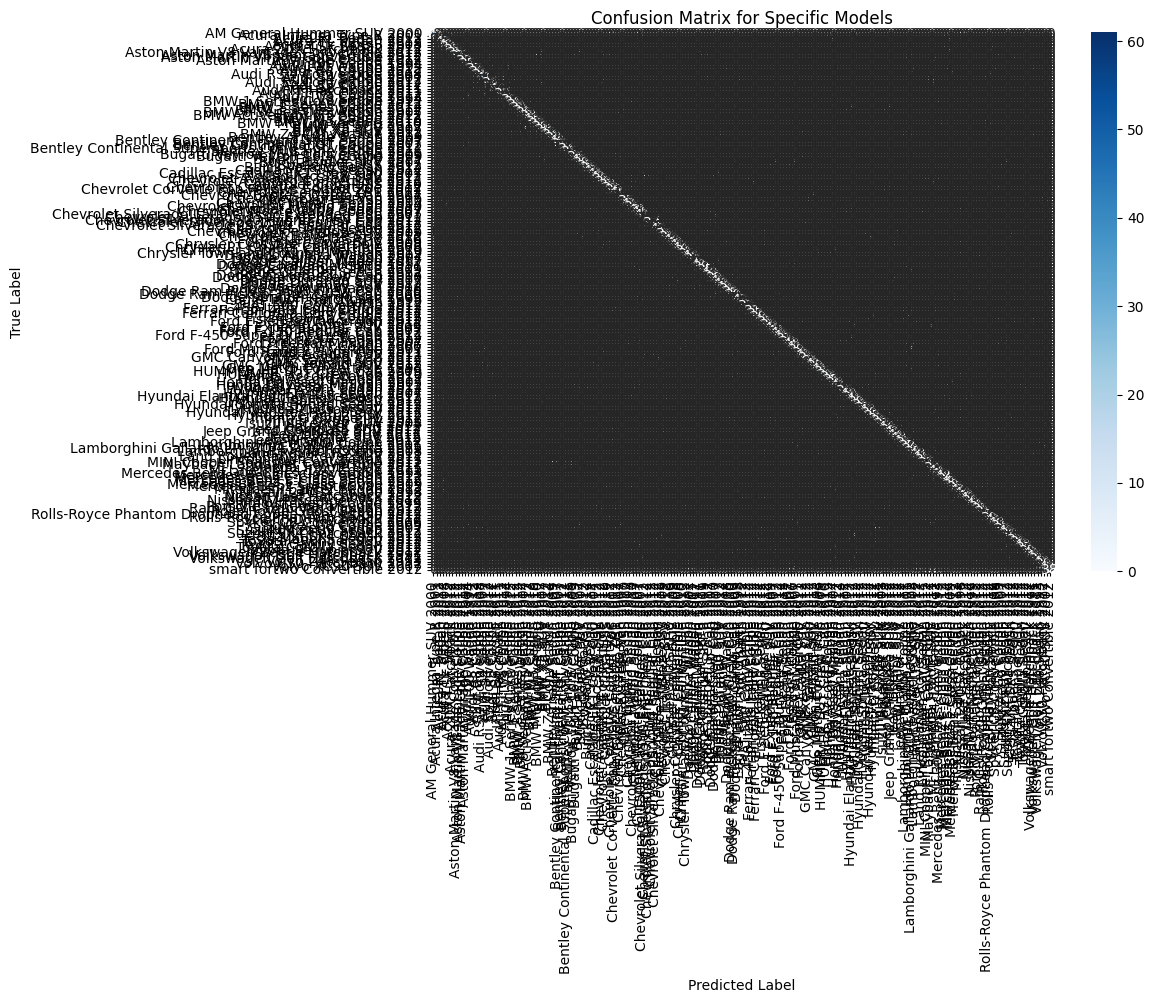

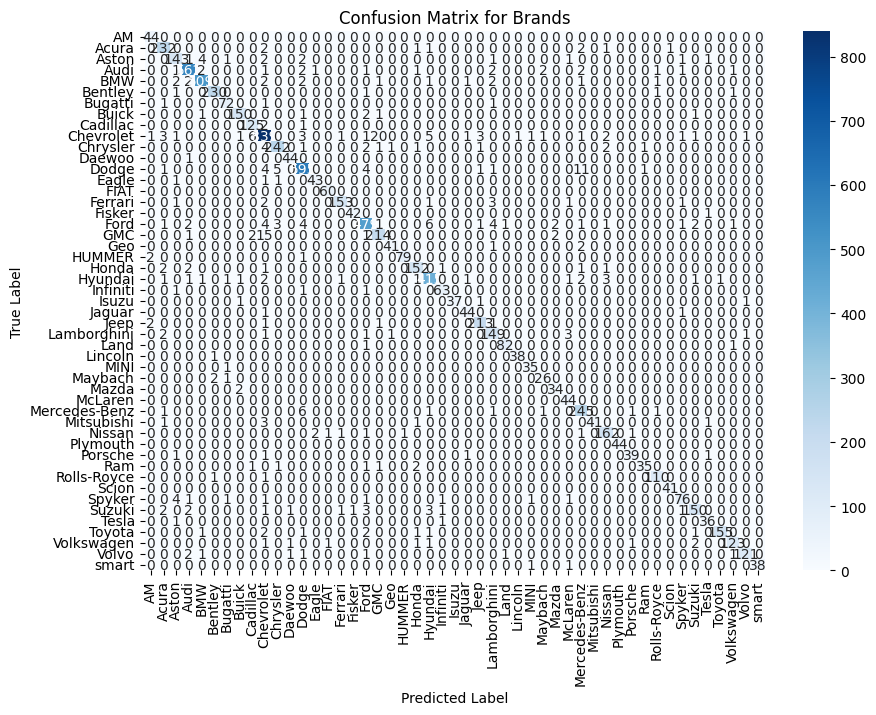

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def plot_confusion_matrix(cm, labels, title):
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

# Supposons que test_loader.dataset.classes contient les étiquettes des classes spécifiques
class_labels = test_loader.dataset.classes

# Supposons que unique_brands contient les étiquettes des marques
unique_brands = sorted(set([extract_brand(name) for name in test_loader.dataset.classes]))

# Convertir les numpy arrays en DataFrames pour une meilleure intégration avec Seaborn
conf_matrix_df = pd.DataFrame(conf_matrix, index=class_labels, columns=class_labels)
conf_matrix_brands_df = pd.DataFrame(conf_matrix_brands, index=unique_brands, columns=unique_brands)

# Appel de la fonction pour afficher les graphiques
plot_confusion_matrix(conf_matrix_df, class_labels, 'Confusion Matrix for Specific Models')
plot_confusion_matrix(conf_matrix_brands_df, unique_brands, 'Confusion Matrix for Brands')

Visualisation

In [25]:
def load_image_from_folder(folder_path, class_name):
    class_folder = os.path.join(folder_path, class_name)
    image_files = os.listdir(class_folder)
    random_image_file = random.choice(image_files)  # Choisir une image aléatoire
    image_path = os.path.join(class_folder, random_image_file)
    print(image_path)
    image = Image.open(image_path)
    return image


def get_class_index(class_name, class_list):
    try:
        return class_list.index(class_name)
    except ValueError:
        print(f"Class '{class_name}' not found in the dataset.")
        return None

In [26]:
class GradCam:
    def __init__(self, model):
        self.model = model
        self.feature_maps = None
        self.gradients = None
        self.model.eval()
        self.hook_layers()

    def hook_layers(self):
        def forward_hook(module, input, output):
            self.feature_maps = output.detach()

        def backward_hook(module, input, output):
            self.gradients = output[0].detach()

        # Assume we are using ResNet-18
        target_layer = self.model.layer4[-1]  # last layer of group 4
        target_layer.register_forward_hook(forward_hook)
        target_layer.register_backward_hook(backward_hook)

    def generate_cam(self, input_image, target_class, class_names):
        self.model.zero_grad()
        output = self.model(input_image)
        class_loss = output[:, target_class]
        class_loss.backward()

        # Obtenir la prédiction de la classe par le modèle
        _, predicted_class_idx = output.max(1)  # Retourne les valeurs maximales et leurs indices

        # Vérification de l'exactitude de la prédiction
        is_correct = (predicted_class_idx.item() == target_class)

        # Obtenir le nom de la classe prédite
        predicted_class_name = class_names[predicted_class_idx.item()]

        # Redimensionnement et moyenne des gradients
        gradient = self.gradients
        pooled_gradients = torch.mean(gradient, dim=[0, 2, 3])

        # Redimensionnement pour correspondre aux cartes de caractéristiques
        for i in range(pooled_gradients.size(0)):
            self.feature_maps[0, i, :, :] *= pooled_gradients[i]

        cam = torch.sum(self.feature_maps, dim=1).squeeze().clamp(min=0)
        cam = torch.nn.functional.interpolate(cam.unsqueeze(0).unsqueeze(0), input_image.shape[2:], mode='bilinear', align_corners=False).squeeze()

        return cam, is_correct, predicted_class_name

In [27]:
# Initialisez le même modèle que celui que vous avez entraîné
model = models.resnet18(pretrained=False)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 196)  # Assurez-vous que cela correspond à votre configuration originale

# Chargez les poids sauvegardés
model.load_state_dict(torch.load("./trainedModelFinal2.pt"))
model.eval()

# Assurez-vous de déplacer le modèle sur le bon appareil (GPU ou CPU)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

/opt/mamba/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/mamba/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


data/stanford-car-dataset-by-classes-folder/car_data/car_data/test/Audi TT Hatchback 2011/03812.jpg
Valid:False
Predicted Class:Ford Ranger SuperCab 2011


/opt/mamba/lib/python3.11/site-packages/torch/nn/modules/module.py:1352: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


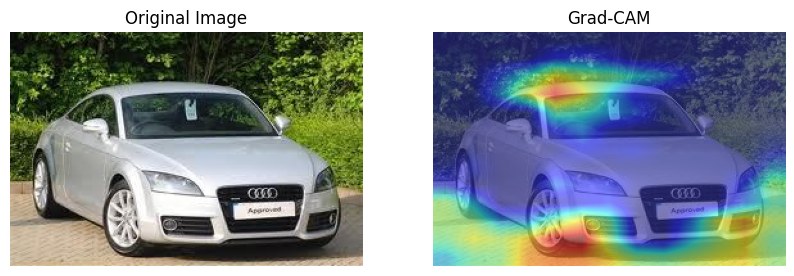

In [28]:
# Charger une image et la transformer
transform = transforms.Compose([
    transforms.Resize((400, 400)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Chemin vers le dossier contenant les données de test
data_folder = 'data/stanford-car-dataset-by-classes-folder/car_data/car_data/test/'

# Choisir une classe spécifique
class_name = 'Audi TT Hatchback 2011'  # Assurez-vous que ce dossier existe

# Charger l'image
img = load_image_from_folder(data_folder, class_name)

# Appliquer les transformations et préparer pour le modèle
input_image = transform(img).unsqueeze(0).to(device)

# Code GradCam ici comme mentionné précédemment
grad_cam = GradCam(model)

# Générer CAM pour une classe spécifique
target_class_index = get_class_index(class_name, train_classes)  # L'index de la classe pour laquelle vous souhaitez voir la carte d'activation
cam, loss, predicted_class = grad_cam.generate_cam(input_image, target_class=target_class_index, class_names=test_loader.dataset.classes)
cam_image = cam.cpu().numpy()  # Assurez-vous que cela fonctionne avec vos dimensions d'image

print("Valid:" + str(loss))
print("Predicted Class:" + predicted_class)


# Visualiser la carte d'activation

# Redimensionner la carte de chaleur pour qu'elle corresponde aux dimensions de l'image originale
cam_image_resized = torch.from_numpy(cam_image).unsqueeze(0).unsqueeze(0)  # Ajouter les dimensions de batch et de canal
cam_image_resized = torch.nn.functional.interpolate(cam_image_resized, size=img.size[::-1], mode='bilinear', align_corners=False)
cam_image_resized = cam_image_resized.squeeze().numpy()  # Enlever les dimensions ajoutées

# Affichage
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(img, alpha=0.8)  # Mettre l'image originale en arrière-plan
plt.imshow(cam_image_resized, cmap='jet', alpha=0.5)  # Superposition de la carte de chaleur
plt.title("Grad-CAM")
plt.axis('off')
plt.show()

Amélioration du modèle en floutant les zones misent en avant par Grad-Cam

In [29]:
import os
import torch
import torch.nn.functional as F
import numpy as np
from torchvision import transforms
from PIL import Image, ImageFilter

# Définition de la classe GradCam
class GradCam:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.feature_maps = None
        self.gradients = None
        self.model.eval()
        self.hook_layers()

    def hook_layers(self):
        def forward_hook(module, input, output):
            self.feature_maps = output.detach()

        def backward_hook(module, input, output):
            self.gradients = output[0].detach()

        target_layer = self.target_layer
        target_layer.register_forward_hook(forward_hook)
        target_layer.register_backward_hook(backward_hook)

    def generate_cam(self, input_image, target_class=None):
        self.model.zero_grad()
        output = self.model(input_image)
        if target_class is None:
            target_class = output.argmax(dim=1)
        class_loss = output[:, target_class]
        class_loss.backward()

        gradient = self.gradients
        pooled_gradients = torch.mean(gradient, dim=[0, 2, 3])

        for i in range(pooled_gradients.size(0)):
            self.feature_maps[0, i, :, :] *= pooled_gradients[i]

        cam = torch.sum(self.feature_maps, dim=1).squeeze().clamp(min=0)
        cam = F.interpolate(cam.unsqueeze(0).unsqueeze(0), size=input_image.shape[2:], mode='bilinear', align_corners=False).squeeze()
        cam = cam - cam.min()
        cam = cam / cam.max()

        return cam

# Configuration présumée pour le modèle et grad_cam
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def load_image(file_path):
    return Image.open(file_path).convert('RGB')

def apply_transforms(image):
    transform = transforms.Compose([
        transforms.Resize((400, 400)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    return transform(image).unsqueeze(0)

def mask_image(image_path, grad_cam):
    img = load_image(image_path)
    input_tensor = apply_transforms(img).to(device)

    # Génération de la carte d'activation
    cam = grad_cam.generate_cam(input_tensor)
    cam_image = cam.cpu().numpy()

    # Redimensionner la carte de chaleur pour qu'elle corresponde aux dimensions de l'image originale
    cam_image_tensor = torch.from_numpy(cam_image).unsqueeze(0).unsqueeze(0)
    cam_resized_tensor = F.interpolate(cam_image_tensor, size=(img.height, img.width), mode='bilinear', align_corners=False)
    cam_resized = cam_resized_tensor.squeeze().numpy()
    
    # Transformation de la carte d'activation en masque
    threshold = 0.7
    mask = cam_resized > threshold

    # Application du flou sur les zones importantes
    img_array = np.array(img)
    blurred_img = img.filter(ImageFilter.GaussianBlur(radius=11))
    blurred_img_array = np.array(blurred_img)
    img_array[mask] = blurred_img_array[mask]

    return Image.fromarray(img_array)

def process_images(input_folder, output_folder, grad_cam):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    
    for filename in os.listdir(input_folder):
     if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
        file_path = os.path.join(input_folder, filename)
        masked_image = mask_image(file_path, grad_cam)
        
        # Séparation du nom de fichier et de son extension
        file_name_no_ext, file_ext = os.path.splitext(filename)
        
        # Construction du nouveau nom de fichier
        new_file_name = file_name_no_ext + 'm' + file_ext
        
        output_path = os.path.join(output_folder, new_file_name)
        masked_image.save(output_path)


def process_all_images_in_train_folder(base_train_folder, grad_cam):
    # Parcourir tous les sous-dossiers du dossier train
    for dirpath, dirnames, filenames in os.walk(base_train_folder):
        # Pour chaque sous-dossier
        for dirname in dirnames:
            input_folder = os.path.join(dirpath, dirname)
            output_folder = os.path.join(dirpath, dirname, "masked")
            
            # Appliquer la fonction process_images sur le sous-dossier actuel
            process_images(input_folder, output_folder, grad_cam)


In [30]:
# Chemin vers le dossier contenant les images et le dossier de sortie
input_folder = '/home/onyxia/work/6milarit-7/data/stanford-car-dataset-by-classes-folder/car_data/car_data/train/Audi TT Hatchback 2011'
output_folder = '/home/onyxia/work/6milarit-7/data/stanford-car-dataset-by-classes-folder/car_data/car_data/train/Audi TT Hatchback 2011'

# Création de l'instance GradCam
# Charger le modèle depuis le fichier sauvegardé
model = models.resnet18(pretrained=False)  # Assurez-vous de définir pretrained=False pour charger un modèle sans les poids pré-entraînés
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 196)  # Remplacez 196 par le nombre de classes de votre ensemble de données

# Charger les poids sauvegardés dans le modèle
model.load_state_dict(torch.load("./trainedModelFinal2.pt"))

# Utilisation du GPU si disponible
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Accéder à la dernière couche convolutive
target_layer = model.layer4[-1]

# Maintenant, vous pouvez utiliser ce target_layer comme vous le souhaitez
  # Remplacez ... par la couche cible sur laquelle vous souhaitez appliquer GradCam
grad_cam = GradCam(model, target_layer)

In [31]:
# Traitement des images d'un dossier
process_images(input_folder, output_folder, grad_cam)

In [11]:

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torchvision.models as models

if __name__ == '__main__':
    # Data transforms
    data_transforms = {
        'train': transforms.Compose([
            transforms.Resize((400,400)),
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(15),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ]),
        'test': transforms.Compose([
            transforms.Resize((400,400)),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ]),
    }

    # Load data
    data_dir = '/home/onyxia/work/6milarit-7/data/stanford-car-dataset-by-classes-folder/car_data/car_data'

    image_datasets = {x: datasets.ImageFolder(
                root=data_dir + '/' + x,
                transform=data_transforms[x])
                for x in ['train', 'test']}

    # Afficher les classes pour l'ensemble de données de formation
    train_classes = image_datasets['train'].classes
    print("Classes in train dataset:", train_classes)

    # Create data loaders
    dataloaders = {x: DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=2)
                   for x in ['train', 'test']}
    dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}

    # Initialize model
    model = models.resnet18(pretrained=True)
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, 196)

    # Utilisation du GPU si disponible
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Dispositif utilisé :", device)
model = model.to(device)

# Identifier la dernière couche convolutive dans ResNet-18
target_layer = model.layer4[-1]

# Enregistrement du modèle
torch.save(model.state_dict(), "./trainedModelFinal4.pt")

# Loss function et optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
scheduler = ReduceLROnPlateau(optimizer, mode='max', patience=3, threshold=0.9)

# Train the model
model, training_losses, training_accs, test_accs = train_model(model, criterion, optimizer, scheduler,
                                                               dataloaders['train'], dataloaders['test'], n_epochs=15)



Classes in train dataset: ['AM General Hummer SUV 2000', 'Acura Integra Type R 2001', 'Acura RL Sedan 2012', 'Acura TL Sedan 2012', 'Acura TL Type-S 2008', 'Acura TSX Sedan 2012', 'Acura ZDX Hatchback 2012', 'Aston Martin V8 Vantage Convertible 2012', 'Aston Martin V8 Vantage Coupe 2012', 'Aston Martin Virage Convertible 2012', 'Aston Martin Virage Coupe 2012', 'Audi 100 Sedan 1994', 'Audi 100 Wagon 1994', 'Audi A5 Coupe 2012', 'Audi R8 Coupe 2012', 'Audi RS 4 Convertible 2008', 'Audi S4 Sedan 2007', 'Audi S4 Sedan 2012', 'Audi S5 Convertible 2012', 'Audi S5 Coupe 2012', 'Audi S6 Sedan 2011', 'Audi TT Hatchback 2011', 'Audi TT RS Coupe 2012', 'Audi TTS Coupe 2012', 'Audi V8 Sedan 1994', 'BMW 1 Series Convertible 2012', 'BMW 1 Series Coupe 2012', 'BMW 3 Series Sedan 2012', 'BMW 3 Series Wagon 2012', 'BMW 6 Series Convertible 2007', 'BMW ActiveHybrid 5 Sedan 2012', 'BMW M3 Coupe 2012', 'BMW M5 Sedan 2010', 'BMW M6 Convertible 2010', 'BMW X3 SUV 2012', 'BMW X5 SUV 2007', 'BMW X6 SUV 2012'

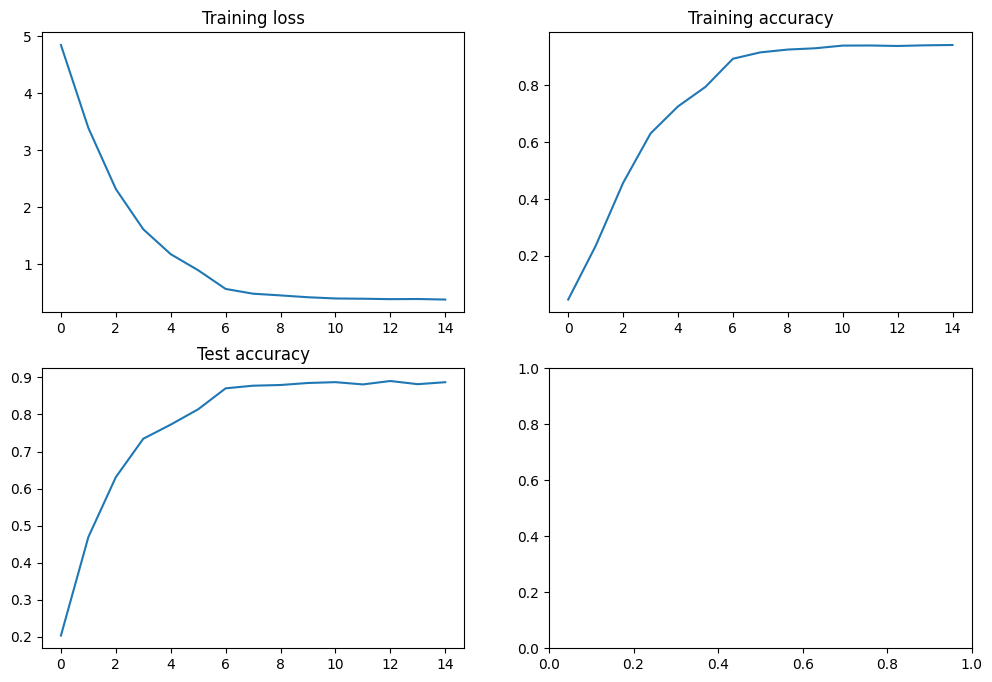

In [12]:
# Save the trained model
#torch.save(model.state_dict(), "./trainedModelFinal.pt")

training_accs_np = [acc.cpu().numpy() if acc.is_cuda else acc.numpy() for acc in training_accs]
test_accs_np = [acc.cpu().numpy() if acc.is_cuda else acc.numpy() for acc in test_accs]

# Plot results
fig, axarr = plt.subplots(2, 2, figsize=(12, 8))
axarr[0, 0].plot(training_losses)
axarr[0, 0].set_title("Training loss")
axarr[0, 1].plot(training_accs_np)
axarr[0, 1].set_title("Training accuracy")
axarr[1, 0].plot(test_accs_np)
axarr[1, 0].set_title("Test accuracy")

plt.show()

In [14]:
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import random
import os
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

# Load data
data_dir = '/home/onyxia/work/6milarit-7/data/stanford-car-dataset-by-classes-folder/car_data/car_data'

image_datasets = {x: datasets.ImageFolder(
            root=data_dir + '/' + x,
            transform=data_transforms[x])
            for x in ['train', 'test']}

# Assuming the DataLoader for 'test' has already been created as per your dataset initialization
test_loader = DataLoader(image_datasets['test'], batch_size=4, shuffle=False)



In [15]:
def extract_brand(class_name):
    return class_name.split()[0]  # Assumant que la marque est le premier mot du nom de classe

def test_model(model, test_loader):
    model.eval()  # Make sure model is in eval mode for testing
    true_labels = []
    predictions = []
    brand_true = []
    brand_predictions = []

    with torch.no_grad():  # No need to track gradients for testing
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # Forward pass
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            # Collect predictions and true labels for each batch
            predictions.extend(preds.view(-1).cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

            # Collect brand predictions and true brand labels
            brand_predictions.extend([extract_brand(test_loader.dataset.classes[pred]) for pred in preds])
            brand_true.extend([extract_brand(test_loader.dataset.classes[label]) for label in labels])

    # Print classification report for specific models
    print("Classification report for specific models:")
    print(classification_report(true_labels, predictions, target_names=test_loader.dataset.classes))

    # Get classification report for brands
    brand_labels = [extract_brand(name) for name in test_loader.dataset.classes]
    unique_brands = sorted(set(brand_labels))  # Get unique brand names for labels in report
    print("Classification report for brands:")
    print(classification_report(brand_true, brand_predictions, labels=unique_brands, target_names=unique_brands))

    # Return confusion matrices for both models and brands
    model_conf_matrix = confusion_matrix(true_labels, predictions)
    brand_conf_matrix = confusion_matrix(brand_true, brand_predictions, labels=unique_brands)

    return model_conf_matrix, brand_conf_matrix

# Run the test function
conf_matrix, conf_matrix_brands = test_model(model, test_loader)

Classification report for specific models:
                                                        precision    recall  f1-score   support

                            AM General Hummer SUV 2000       0.88      0.98      0.92        44
                             Acura Integra Type R 2001       0.93      0.93      0.93        44
                                   Acura RL Sedan 2012       0.87      0.81      0.84        32
                                   Acura TL Sedan 2012       0.82      0.98      0.89        43
                                  Acura TL Type-S 2008       0.98      1.00      0.99        42
                                  Acura TSX Sedan 2012       0.97      0.90      0.94        40
                              Acura ZDX Hatchback 2012       0.94      0.79      0.86        39
              Aston Martin V8 Vantage Convertible 2012       0.88      0.64      0.74        45
                    Aston Martin V8 Vantage Coupe 2012       0.89      0.83      0.86       